# Transformations Tutorial #2: The Coordinate System Manager

## Imports

In [1]:
# enable interactive plots on Jupyterlab with ipympl and jupyterlab-matplotlib installed
# %matplotlib widget

In [2]:
from copy import deepcopy


import numpy as np
import xarray as xr
from weldx import Q_, CoordinateSystemManager, LocalCoordinateSystem, WXRotation

## Introduction

This tutorial is about the `CoordinateSystemManager` (CSM) class of the `weldx.transformations` package. It builds upon the [tutorial about coordinate systems](transformations_01_coordinate_systems.ipynb), but the content of this tutorial can still be understood without reading the other one first.

The purpose of the `CoordinateSystemManager` is to define and manage the relationships of different coordinate systems and their associated data in a tree-like data structure. It provides methods to transform a `LocalCoordinateSystem` (LCS) or its data to an arbitrary other coordinate system.

> HINT: 
> This tutorial contains interactive plots. 
> In the readthedocs/html version of this tutorial, the function set is very limited.
> By clicking on the binder-link at the top of the document, you can start a fully interactive jupyter-lab online session of this tutorial.

## Create a CSM and add coordinate systems

The creation of `CoordinateSystemManager` requires the name of the root coordinate system as parameter. As optional second parameter, we can give the `CoordinateSystemManager` instance a name. If no name is provided, it will get a default name.

In [3]:
csm = CoordinateSystemManager("root", "My CSM")

Further coordinate systems can be added with the `add_cs` member function of the `CoordinateSystemManager`. 
It expects 4 parameters with the fourth being optional. 
The first parameter is the name of the new coordinate system. 
The second parameter is the name of an already existing coordinate system in which is the reference system of the new one. 
The third parameter is a `LocalCoordinateSystem` that describes the position and orientation of the new coordinate system in its reference system.
In case you only have the inverse data, meaning the position and orientation of the reference system inside the new coordinate system, you can set the fourth parameter (`lsc_child_in_parent`) to `False` and use the corresponding data instead.

In [4]:
lcs_specimen_in_root = LocalCoordinateSystem(coordinates=Q_([0, 1, -2], "mm"))
lcs_specimen_in_thermocouple = LocalCoordinateSystem(coordinates=Q_([-1, -1, 0], "mm"))

csm.add_cs("specimen", "root", lcs_specimen_in_root)
csm.add_cs(
    "thermocouple", "specimen", lcs_specimen_in_thermocouple, lsc_child_in_parent=False
)

Additionally, the `CoordinateSystemManager` provides some functions that create the `LocalCoordinateSystem` internally. 
The method `create_cs` takes the name of the new coordinate system and its reference system as first two parameters. 
The remaining parameters and their default values are identical to the ones from the `LocalCoordinateSystem.__init__` method. 
Similarly, there are functions for each of the ´LocalCoordinateSystem´s construction/factory methods (`from_euler`, `from_xyz`, etc.). 
The naming is simply `create_cs_` plus the name of the corresponding function of the `LoocalCoordinateSystem`. 
For example `construct_cs_from_euler`. 
As with `add_cs`, the last parameter of all those methods is `lsc_child_in_parent` which can be set to `False` if the provided values represent the orientation and coordinates of the reference system in the new child system.

In [5]:
csm.create_cs_from_euler(
    "flange",
    "root",
    sequence="x",
    angles=20,
    degrees=True,
    coordinates=Q_([-1, -1, 2], "mm"),
)
csm.create_cs("torch", "flange", coordinates=Q_([0, 0, -1], "mm"))

Please consult the [API documentation of the CSM](https://weldx.readthedocs.io/en/latest/_autosummary/weldx.CoordinateSystemManager.html#weldx.CoordinateSystemManager) to get an overview over the different LCS creation methods and their parameters

## Visualizing the coordinate system managers structure

The internal structure of the `CoordinateSystemManager` is a tree. We can visualize it using the `plot_graph` function:

<AxesSubplot:>

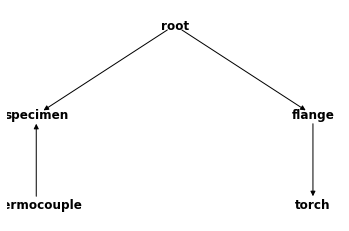

In [6]:
csm.plot_graph()

Inside of an ipython notebook it is sufficient to place the name of a `CoordinateSystemManager` instance at the end of a code cell to plot its graph:

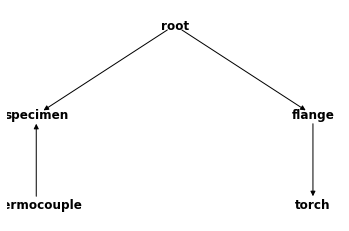

In [7]:
csm

## Getting coordinate systems and transformations to another reference system

Getting a coordinate system in relation to any other reference system in form of a `LocalCoordinateSystem` class is quite easy. 
Simply call `get_cs`. 
The name of the system that should be transformed is passed to the function as first parameter. 
The second parameter is the name of the target reference system. 
Let's try this for some coordinate systems:

In [8]:
csm.get_cs("specimen", "root") == lcs_specimen_in_root

True

Here we get a coordinate system we added directly to the CSM.
Therefore, no transformation is needed and the equality check is passed.
If we want to get a coordinate system inside of its parent system, we can omit the second parameter as proven below:

In [9]:
csm.get_cs("specimen", "root") == csm.get_cs("specimen")

True

However, note that the returned coordinate system is not necessarily identical to the one that we used during the definition.
If we were setting the `lsc_child_in_parent` during the addition of the coordinate system to `False`, we provided the inverse transformation:

In [10]:
csm.get_cs("thermocouple") == lcs_specimen_in_thermocouple

False

In [11]:
csm.get_cs("specimen", "thermocouple") == lcs_specimen_in_thermocouple

True

Let's get the coordinate "thermocouple" coordinate system in reference to the "root" system:

In [12]:
csm.get_cs("thermocouple", "root")

<LocalCoordinateSystem>
Dimensions:      (c: 3, v: 3)
Coordinates:
  * c            (c) <U1 'x' 'y' 'z'
  * v            (v) int32 0 1 2
Data variables:
    orientation  (v, c) float64 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0
    coordinates  (c) float64 [mm] 1.0 2.0 -2.0

Since the coordinate systems along the transformation path ("thermocouple", "specimen", "root") are not rotated, the coordinates of the resulting coordinate system is simply the sum of the individual coordinates:

In [13]:
coords_transformed = csm.get_cs("thermocouple", "root").coordinates.data
coords_sum = (
    csm.get_cs("thermocouple").coordinates + csm.get_cs("specimen").coordinates
).data

np.all(coords_transformed == coords_sum)

True

As you can see, getting coordinate systems in reference to any of the other coordinate systems of the CSM is quite easy.

# Visualizing the coordinate systems of the CSM

You can visualize all coordinate systems of the CSM in relation to each other by using its `plot` function.
The `backend` parameter defines which rendering engine should be used.
We will use `"mpl"` to use matplotlib first:

> HINT: Note that you need the weldx-widgets package installed to use this functionality. Either use `pip install weldx-widgets` or `conda install weldx_widgets -c conda-forge` to install it

<Axes3DSubplot:xlabel='x', ylabel='y'>

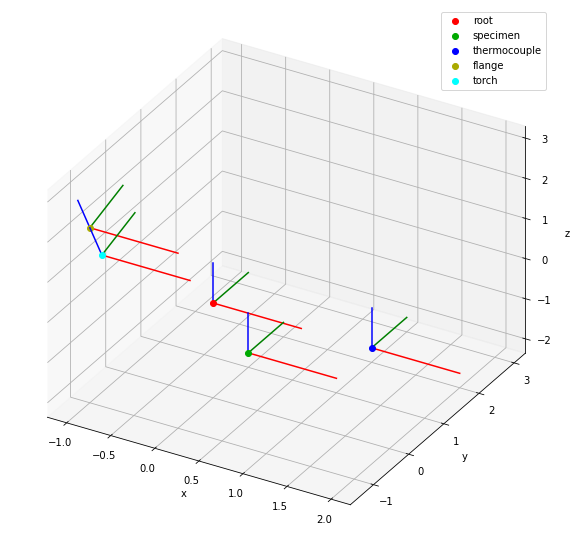

In [14]:
csm.plot(backend="mpl")

By default the root coordinate system is the reference system of the plot, but we can change it using the `reference_system` parameter as follows:

<Axes3DSubplot:xlabel='x', ylabel='y'>

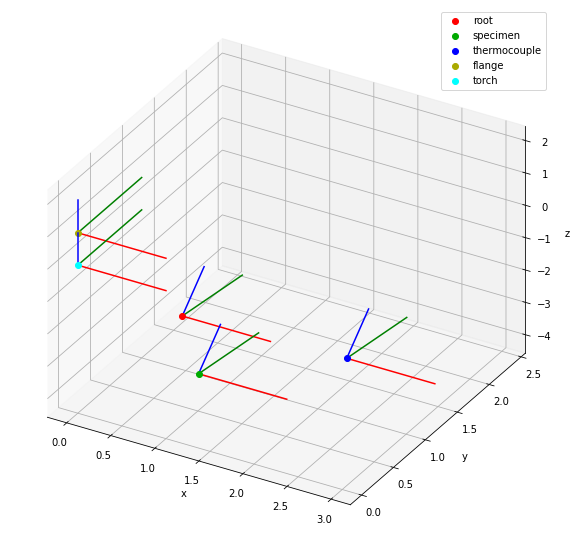

In [15]:
csm.plot(reference_system="torch", backend="mpl")

The plot function has many other options that can be used to adjust the apearance of the plot.
Consult the [function documentation](https://weldx.readthedocs.io/en/latest/_autosummary/weldx.CoordinateSystemManager.plot.html#weldx.CoordinateSystemManager.plot) for further details.

If you are running a jupyter notebook, you can use k3d as rendering backend.
It has a much more powerful rendering engine suited for 3d plots that can handle a vast amount of data and provides an interactive rendering window.
Furthermore, the `plot` function of the CSM creates some additional control surfaces if k3d is used.
This gives you the opportunity to modify the plot directly using buttons, checkboxes, sliders, etc. instead of recreating it with a different set of function parameters: 

> HINT: Note that some of the interactive functionality can't be used in the readthedocs documentation. Click on the binder link at the top of the document to start a jupyter-lab session that runs this tutorial online.

In [16]:
csm.plot(backend="k3d")

Output()

## Renaming existing coordinate systems
Existing coordinate system nodes can be renamed using the `relabel` method.
It expects a dictionary that maps old names to new ones as input.

*Note: it is not possible to rename nodes on `CSM` instances that contain subsystems of any form.*

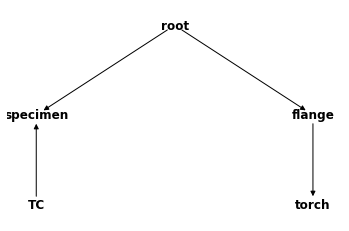

In [17]:
csm.relabel({"thermocouple": "TC"})
csm

## Updating and deleting coordinate system transformations

A coordinate system can be updated by simply calling `add_cs` again with the correct reference system and an updated `LocalCoordinateSystem` instance. 
For example, to update the torch system, one could do the following:

In [18]:
csm.add_cs("torch", "flange", LocalCoordinateSystem(coordinates=Q_([0, 0, -2], "mm")))

Lets check if the values have changed

In [19]:
csm.get_cs("torch", "flange")

<LocalCoordinateSystem>
Dimensions:      (c: 3, v: 3)
Coordinates:
  * c            (c) <U1 'x' 'y' 'z'
  * v            (v) int32 0 1 2
Data variables:
    orientation  (v, c) float64 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0
    coordinates  (c) float64 [mm] 0.0 0.0 -2.0

As you can see, the system has been updated. 

If you want to remove a coordinate system, you have to call `delete_cs`. 
The function takes two parameters. 
The first one is the name of the coordinate system you want to delete. 
The second is a `bool` that controls if child coordinate systems should be deleted too or not. 
In case you set this parameter to `False` (default) and try to remove a coordinate system with children, an exception is raised. 
This is an extra layer of security to prevent unintentional deletion of multiple coordinate systems. 
Here is an example:

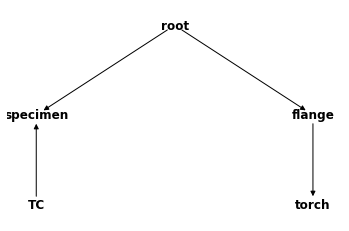

In [20]:
csm_copy = deepcopy(csm)
csm_copy

We made a copy of the `CoordinateSystemManager`.
Now we are going to delete the specimen system, which has no other systems attached to it.

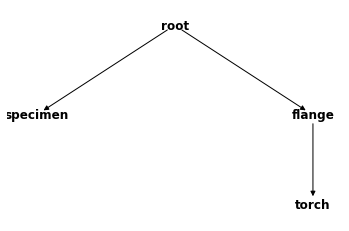

In [21]:
csm_copy.delete_cs("TC")
csm_copy

That worked. Now lets try to remove the flange system:

In [22]:
try:
    csm_copy.delete_cs("flange")
except Exception as e:
    print(f"Something went wrong! The following exception was raised:\n{e}")

Something went wrong! The following exception was raised:
Can not delete coordinate system "flange". It has one or more children that would be disconnected to the root after deletion. Set the delete_children option to "True" to delete the coordinate system and all its children. The attached child systems are: ['torch']


Since the torch system is a child of the flange system and we didn't tell the function to delete child systems as well, an exception was raised. Lets retry this, but this time we will tell the function that we want child systems to be removed too:

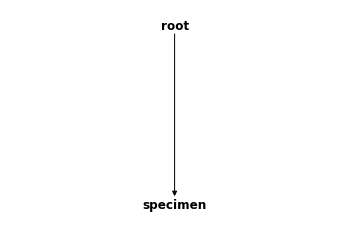

In [23]:
csm_copy.delete_cs("flange", True)
csm_copy

As you can see, we were successful and only the "root" and "specimen" coordinate systems are left in the `CoordinateSystemManager` instance.

## Assignment and transformation of spatial data

A coordinate system stored in the `CoordinateSystemManager` can also get spatial data assigned to it. 
For example, this might be a sensor positions or geometry data in form of a point clouds. 
In this case it becomes the data's reference system and all values refer to its coordinate origin. 

Data can be assigned to a coordinate system with the `assign_data` function. 
It expects 3 parameters. 
The first one is the actual data. 
This can either be an `SpatialData` instance or an `xarray.DataArray`. 
The second parameter is a name of the data and the third one the name of the coordinate system that the data belongs to. 
In the following lines we define and assign some data to the `CoordinateSystemManager`.
Let's create some data first:

In [24]:
from weldx import SpatialData

sensor_positions_in_root = xr.DataArray(
    Q_([[0, -1, 0], [0, -2, 0]], "mm"), dims=["n", "c"], coords={"c": ["x", "y", "z"]}
)

points = Q_([[0, 1, -1], [2, 1, -1], [0, 4, -1], [2, 4, -1]], "mm")
triangles = [[0,1,2],[2,3,1]]
specimen_geometry_in_specimen = SpatialData(points, triangles)

The `SpatialData` class we used above is mostly a container class for 3d data.
Additionally to pure point data, it can also store connectivety data in form of triangles.
Consult the [class documentation](https://weldx.readthedocs.io/en/latest/_autosummary/weldx.SpatialData.html#weldx.SpatialData) for further information.
Now we add the data to the CSM:

In [25]:
csm.assign_data(sensor_positions_in_root, "sensors", "root")
csm.assign_data(specimen_geometry_in_specimen, "specimen geometry", "specimen")

With the `get_data` function, the unmodified data can be retrieved from the `CoordinateSystemManager` using its name as first parameter. 

In [26]:
assert sensor_positions_in_root.identical(csm.get_data("sensors"))

The optional second parameter can be used to get the data transformed into any of the `CoordinateSystemManager`s coordinate systems. You just need to specify the desired target coordinate systems name:

In [27]:
csm.get_data("specimen geometry", "root")

SpatialData(coordinates=<xarray.DataArray (n: 4, c: 3)>
<Quantity([[ 0.  2. -3.]
 [ 2.  2. -3.]
 [ 0.  5. -3.]
 [ 2.  5. -3.]], 'millimeter')>
Coordinates:
  * c        (c) <U1 'x' 'y' 'z'
Dimensions without coordinates: n, triangles=array([[0, 1, 2],
       [2, 3, 1]], dtype=uint32), attributes=None)

By default, the `plot` method will also visualize attached data.
Here is an interactive plot of the CSM with the newly added data.
You can change the reference system using the control surfaces.

In [28]:
csm.plot(backend="k3d")

C:\Users\vhirtham\Miniconda3\envs\weldx\lib\site-packages\traittypes\traittypes.py:97: UserWarning: Given trait value dtype "int32" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Output()

A nice feature of attached `SpatialData` instances is that they are visualized with closed surfaces if they contain triangle data.
In contrast, `xarray.DataArray` instances are always rendered as point clouds.

It is not necessary to attach data to a coordinate system to transform it to another one. The `CoordinateSystemManager` also provides the `transform_data` function for this purpose. It expects 3 parameters. The first parameter is the actual data and must be a `numpy.ndarray` or an `xarray.DataArray`. The second one is the source system name and the third one the target systems' name:

In [29]:
csm.transform_data(sensor_positions_in_root, "root", "specimen")

Magnitude,[[0.0 -2.0 2.0] [0.0 -3.0 2.0]]
Units,mm


## Time dependencies

As described in the [previous tutorial about the `LocalCoordinateSystem` class](transformations_01_coordinate_systems.ipynb), the orientation of a coordinate system towards its reference system might vary in time.
From the API side, time dependent coordinate systems are not treated any different than constant coordinate systems.
However, the `get_cs` function needs to perform some time interpolations internally if the timestamps of all involved coordinate systems aren't identical.
You might wonder which times the resulting interpolated `LocalCoordinateSystem` possesses.
The default behavior is that its timestamps are the time union of all coordinate systems participating in the transformation.
However, you can also provide the desired timestamps using the `time` parameter of the `get_cs` function. 

Let's define a new `CoordinateSystemManager` to demonstrate the different approaches:

In [30]:
csm_tdp = CoordinateSystemManager("root")

csm_tdp.create_cs(
    "parent",
    "root",
    coordinates=Q_([[1, -1, 0], [0, -1, 0]], "mm"),
    orientation=-WXRotation.from_euler("z", [0, np.pi / 2]).as_matrix(),
    time=Q_([1, 6], "days"),
)

csm_tdp.create_cs(
    "child",
    "parent",
    coordinates=Q_([0, 2, 0], "mm"),
    orientation=WXRotation.from_euler("z", [0, np.pi / 2]).as_matrix(),
    time=Q_([2, 5], "days"),
)

csm_tdp.create_cs(
    "child child",
    "child",
    coordinates=Q_([2, 0, 0], "mm"),
    orientation=WXRotation.from_euler("z", [0, np.pi / 2]).as_matrix(),
    time=Q_([3, 4], "days"),
)

Now we plot the CSM:

In [31]:
csm_tdp.plot(backend="k3d")

Output()

As you can see, the traces of the time dependent coordinate systems are drawn into the plot.
You can hide them by unchecking the corresponding checkbox.
You can also use the slider or the "play" button to cycle through the different time steps.

Now we use `get_cs` with a specific `time` to transform all coordinate systems to the `"root"` system, create a new CSM with this data and plot it: 

In [32]:
time = Q_([(i + 1) for i in range(120)], "hours")

csm_tdp_2 = CoordinateSystemManager("root")

system_names = ["parent", "child", "child child"]

for name in system_names:
    lcs = csm_tdp.get_cs(name, "root", time=time)
    csm_tdp_2.add_cs(name, "root", lcs)
    
csm_tdp_2.plot(backend="k3d")

Output()

If you take a look at the trace of the coordinate system that follows a circular path, you will notice that it looks much smoother now.
Use the time controls and you will see that the data grid is now much denser.

We can also tell the `get_cs` method to interpolate all coordinate systems to match the timestamps of one of the CSMs time dependent coordinate systems.
Therefore, we simply provide the target systems name as `time` parameter:

In [33]:
csm_tdp_3 = CoordinateSystemManager("root")

system_names = ["parent", "child", "child child"]

for name in system_names:
    lcs = csm_tdp.get_cs(name, "root", time="parent")
    csm_tdp_2.add_cs(name, "root", lcs)
    
csm_tdp_2.plot(backend="k3d")

Output()

In the previous two examples we used the `get_cs` method to interpolate the coordinate system data and create a new CSM from it.
The purpose was to showcase how `get_cs` works with time dependent coordinate systems.
However, if you just want to get an interpolated copy of a CSM, it is much simpler to use its `interp_time` method:

In [34]:
time = time = Q_([(i + 1) for i in range(120)], "hours")

csm_tdp_3 = csm_tdp.interp_time(time = time)

csm_tdp_3.plot(backend="k3d")

Output()

You can also limit the time interpolation to certain coordinate systems by using the `affected_coordinate_systems` parameter.
It expects a list of coordinate system names.

In [35]:
time = Q_([3600, 7200], "minutes")

csm_tdp_4 = csm_tdp.interp_time(time=time, affected_coordinate_systems=["child", "child child"]) 

The following comparisons show that it worked:

In [36]:
np.all(csm_tdp_4.get_cs("parent").time == time)

False

In [37]:
np.all(csm_tdp_4.get_cs("child").time == time)

True

In [38]:
np.all(csm_tdp_4.get_cs("child child").time == time)

True

## Merging and unmerging

Sometimes a larger hierarchy of coordinate systems can be subdivided into multiple smaller subsystems.
Defining them individually might be more intuitive and easier.
For this reason, the `CoordinateSystemManager` provides the possibility to merge an instance into another one.
We will introduce this functionality with a short example.

Consider an automated welding process, where the torch is moved by a robot arm.
The robot provides two mount points for additional equipment.
We know where the torch and the mount points are located in the moving robot head coordinate system.
So we can define the following `CoordinateSystemManager` instance to describe the setup:

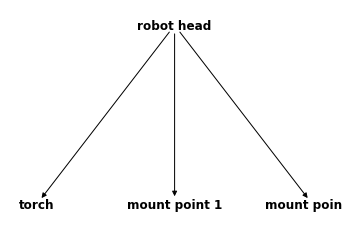

In [39]:
csm_robot = CoordinateSystemManager("robot head", "robot coordinate systems")
csm_robot.create_cs("torch", "robot head", coordinates=Q_([0, 0, -2], "mm"))
csm_robot.create_cs("mount point 1", "robot head", coordinates=Q_([0, 1, -1], "mm"))
csm_robot.create_cs("mount point 2", "robot head", coordinates=Q_([0, -1, -1], "mm"))
csm_robot

As extra measurement equipment we have a laser scanner that we want to attach to the first mounting point. 
It uses its own coordinate system and all the gathered data refers to it. 
We know the coordinates of the scanners own mount point inside this system so that we can define:

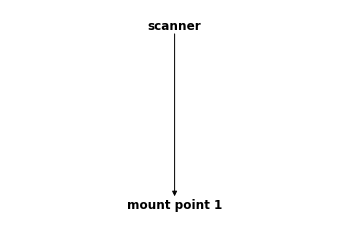

In [40]:
csm_scanner = CoordinateSystemManager("scanner", "scanner coordinate systems")
csm_scanner.create_cs("mount point 1", "scanner", coordinates=Q_([0, 0, 2], "mm"))
csm_scanner

Note that the coordinate system "mount point 1" was added to both `CoordinateSystemManager` instances. 
Merging requires that both instances share exactly one common coordinate system that serves as connecting node.

Now we merge the scanner coordinate systems with the robot coordinate systems using the `merge` function:

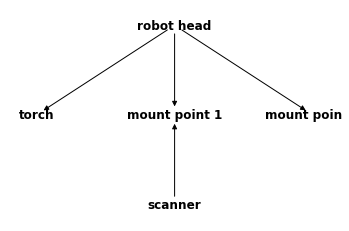

In [41]:
csm_robot.merge(csm_scanner)
csm_robot

You can see in the output above that the scanner coordinate systems were successfully merged into the `CoordinateSystemManager` instance containing the robot data. Let's define some additional `CoordinateSystemManager` instances:

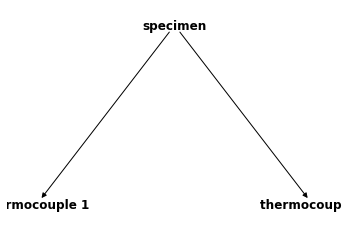

In [42]:
csm_specimen = CoordinateSystemManager("specimen", "specimen coordinate systems")
csm_specimen.create_cs("thermocouple 1", "specimen", coordinates=Q_([1, 1, 0], "mm"))
csm_specimen.create_cs("thermocouple 2", "specimen", coordinates=Q_([1, 4, 0], "mm"))
csm_specimen

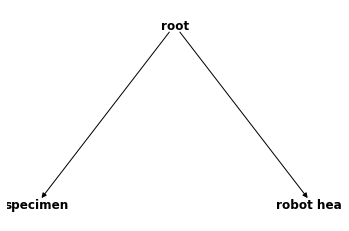

In [43]:
csm_global = CoordinateSystemManager("root", "global coordinate systems")
csm_global.create_cs("specimen", "root", coordinates=Q_([1, 2, 3], "mm"))
csm_global.create_cs("robot head", "root", coordinates=Q_([4, 5, 6], "mm"))
csm_global

Now we merge them all:

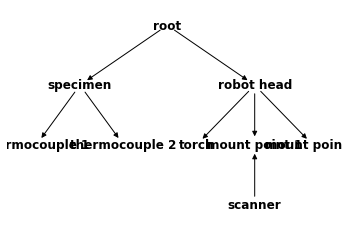

In [44]:
csm_global.merge(csm_robot)
csm_global.merge(csm_specimen)
csm_global

All coordinate systems are now collected in a single `CoordinateSystemManager`.
We can extract the previously merged subsystems with the function `subsystems` property.
It returns a list with the `CoordinateSystemManager` instances:

In [45]:
csm_list = csm_global.subsystems
for sub_csm in csm_list:
    print(sub_csm.name)

robot coordinate systems
specimen coordinate systems


Comparing the returned `CoordinateSystemManager` instances with the original ones shows that they are indeed identical:

In [46]:
for sub_csm in csm_list:
    if sub_csm.name == "robot coordinate systems":
        print(sub_csm == csm_robot)
    else:
        print(sub_csm == csm_specimen)

True
True


You might have noticed, that there is no `CoordinateSystemManager` for the scanner systems.
The reason for this is that it is a subsystem of the robot coordinate systems and the `subsystems` property does not recursively extract nested subsystems.
However, we can simply use `subsystems` a second time to get it:

In [47]:
for sub_csm in csm_list:
    if sub_csm.name == "robot coordinate systems":
        print(sub_csm.subsystems[0].name)

scanner coordinate systems


Using the `subsystems` property does not affect the state of the current `CoordinateSystemManager`:

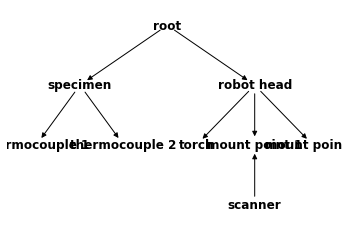

In [48]:
csm_global

To remove all subsystems, you can call `remove_subsystems`:

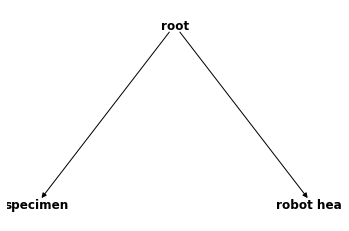

In [49]:
csm_global.remove_subsystems()
csm_global

Alternatively, if you want to decompose a `CoordinateSystemManager` instance into all its subsystems, you can use the `unmerge` function.
It works exactly the same as the `subsystems` property with the difference that it also removes all subsystem data from the affected `CoordinateSystemManager` instance.